In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from tqdm import tqdm
import spacy
import re
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation

# lemmatize = spacy.load("en_core_web_sm")


### Load data

In [2]:
data = pd.read_json("putin_complete.json")

### Preprocessing

In [3]:
stop_words = set(stopwords.words('english'))

In [4]:
transcripts = np.array(data["transcript_filtered"])
dates = data["date"].reset_index(drop=True)
punctuation = [".", ",", "?", "!", ":", "`", "'", "(", ")", "[", "]", "/", '’', "-", "’s", "\"", ";", "i", " ", "–", "%", "*", "..."]
lemmatize = spacy.load("en_core_web_sm")
transcripts_processed = {}

for id in tqdm(range(len(transcripts)), "Removing stop words..."):
    curr_date =  dates[id].strftime('%Y-%m')
    if curr_date not in transcripts_processed.keys():
        transcripts_processed[curr_date] = []
    transcripts_processed[curr_date] = transcripts_processed[curr_date] + [
        w.lemma_.lower() for w in lemmatize(transcripts[id]) if not (w.lemma_ in stop_words or w.lemma_.lower() in punctuation or " " in w.lemma_)
    ]

Removing stop words...: 100%|██████████| 9838/9838 [11:26<00:00, 14.33it/s]


### EDA & Some Analysis

In [5]:
all_words = []
token_counts = []
for k, v in transcripts_processed.items():
    all_words += v
    token_counts.append(len(v))

word_frequencies = pd.Series(all_words).value_counts()

In [6]:
print(f"Average length of monthly speeches in token count: {int(np.sum(token_counts) / len(list(transcripts_processed.keys())))}")

Average length of monthly speeches in token count: 15772


In [7]:
print(f"Average token length: {np.round(np.mean([len(word) for word in all_words]), 2)}")

Average token length: 6.41


In [8]:
all_ngrams = []

for k, v in transcripts_processed.items():
    all_ngrams += list(ngrams(v, 5))

In [9]:
def find_words_near_poland(ngrams):
    words_near_poland = []
    for ngram in ngrams:
        if "poland" in ngram or "polish" in ngram:
            for word in ngram:
                if not word.__eq__("poland") and not word.__eq__("polish"):
                    words_near_poland.append(word)
    
    return words_near_poland

In [10]:
# Words used near word Poland
pd.Series(find_words_near_poland(all_ngrams)).value_counts()[:10]

russian      229
russia       227
relation     156
people       151
germany      128
minister     123
republic     119
romania      119
country      117
president    114
Name: count, dtype: int64

In [11]:
words_near = []

for k, v in transcripts_processed.items():
    words_near.append(find_words_near_poland(list(ngrams(v, 5)))[:10])

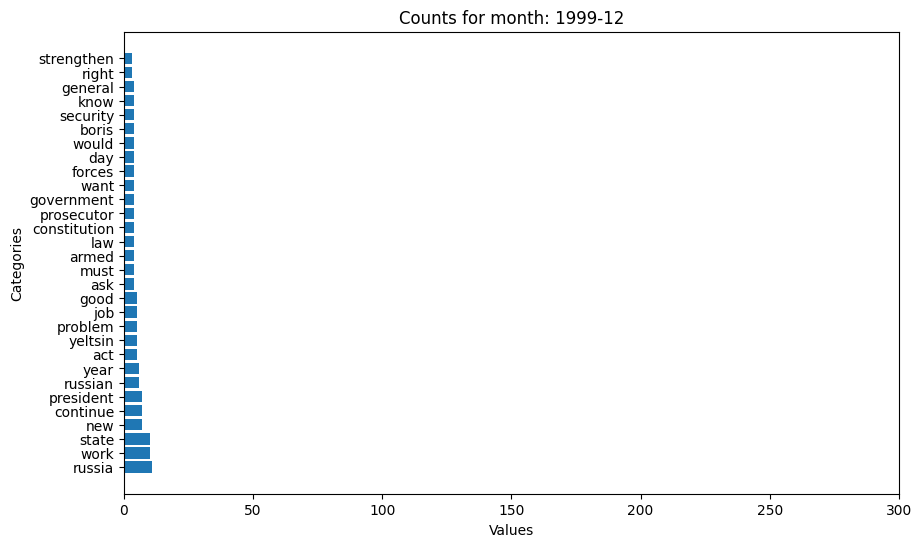

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    curr_key = list(transcripts_processed.keys())[frame]
    transcripts_processed
    counts = pd.Series(transcripts_processed[curr_key]).value_counts()
    ax.clear()
    plt.barh(counts[:30].index, counts[:30].values)
    ax.set_xlabel("Values")
    ax.set_ylabel("Categories")
    ax.set_title(f"Counts for month: {curr_key}")
    ax.set_xlim(0, 300)

num_frames = len(transcripts_processed.keys())
ani = FuncAnimation(fig, update, frames=num_frames, repeat=True, interval=1000)

ani.save("counts.gif", writer='pillow')

In [13]:
def get_token_encounters(token):
    encounters = []
    dates = []
    for k, v in transcripts_processed.items():
        dates.append(k)
        counts = pd.Series(v).value_counts()
        try:
            encounters.append(counts[token])
        except:
            encounters.append(0)
    
    return encounters, dates

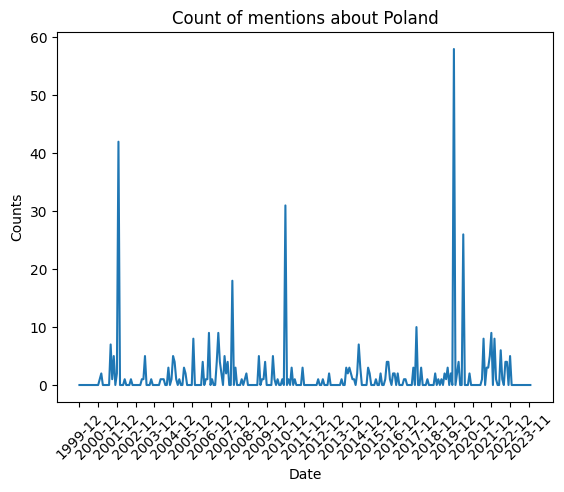

In [19]:
pol_encounters, dates = get_token_encounters("poland")

plt.plot(dates, pol_encounters)
plt.xlabel("Date")
plt.ylabel("Counts")
plt.title("Count of mentions about Poland")
plt.xticks(rotation=45, ticks=range(0, len(dates), 12))
plt.show()

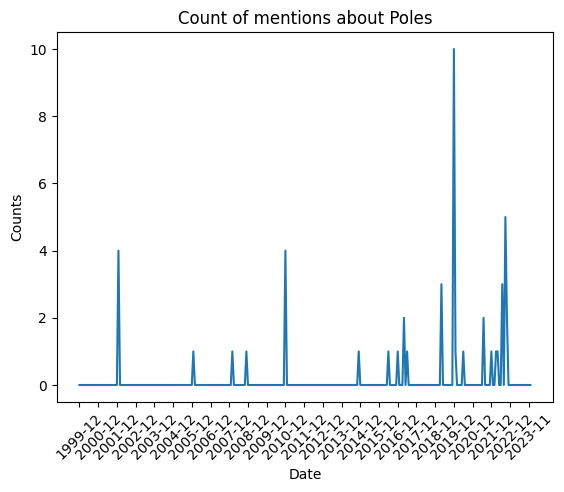

In [95]:
pol_encounters, dates = get_token_encounters("poles")

plt.plot(dates, pol_encounters)
plt.xlabel("Date")
plt.ylabel("Counts")
plt.title("Count of mentions about Poles")
plt.xticks(rotation=45, ticks=range(0, len(dates), 12))
plt.show()

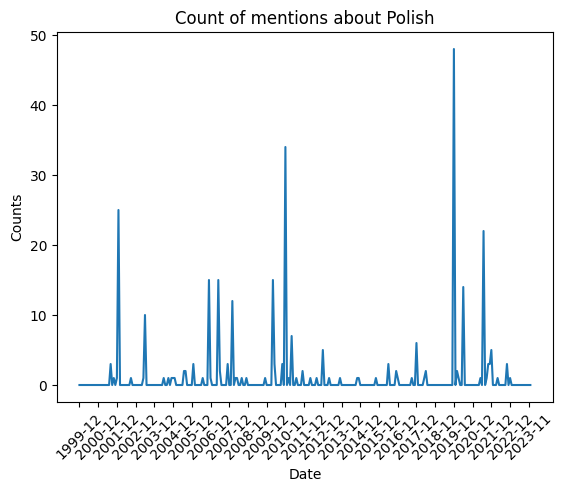

In [96]:
pol_encounters, dates = get_token_encounters("polish")

plt.plot(dates, pol_encounters)
plt.xlabel("Date")
plt.ylabel("Counts")
plt.title("Count of mentions about Polish")
plt.xticks(rotation=45, ticks=range(0, len(dates), 12))
plt.show()

In [102]:
speeches_processed = {}
for date, speech in transcripts_processed.items():
    speeches_processed[date] = " ".join(speech)


vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(list(speeches_processed.values()))

In [103]:
tfidf_dict = {}
for ele1, ele2 in zip(vectorizer.get_feature_names_out(), vectorizer.idf_):
   if ele2 < 5.5:
      tfidf_dict[ele1] = np.round(ele2, 5)

In [104]:
tfidf_values = list(tfidf_dict.values())
tfidf_keys = list(tfidf_dict.keys())
sorting_perm = sorted(range(len(tfidf_values)), key=lambda i: tfidf_values[i])

# print(np.array(tfidf_values)[sorting_perm])
# print(np.array(tfidf_keys)[sorting_perm][-100:])

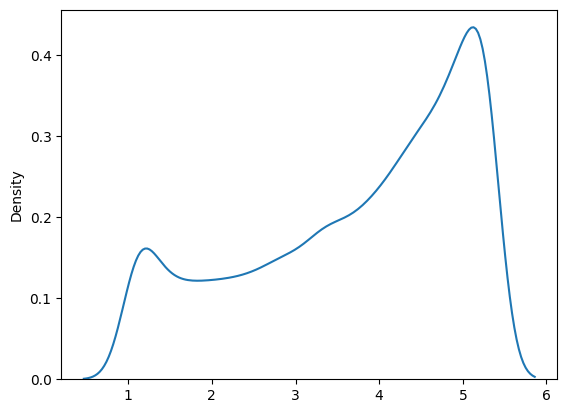

In [105]:
sns.kdeplot(np.array(tfidf_values)[sorting_perm])
plt.show()

In [107]:
poland_words_list = ["poland", "polish", "poles"]
speeches_mentioning_poland = {}
for date, speech in speeches_processed.items():
    if any(pol_word in speech for pol_word in poland_words_list):
        speeches_mentioning_poland[date] = speech

In [119]:
list(speeches_mentioning_poland.values())[0][:500]

'first would like thank federal chancellor accept invitation come russia fact federal chancellor arrive time orthodox christmas outset give visit positive outlook well receive moscow think judge reaction muscovite business side meeting say long detailed talk european development relation europe russia near future long term glad learn hear personally one leader europe germany perceive development relation united europe russia russia germany believe — familiar russia position — use force yugoslavia'

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

inputs = tokenizer(, return_tensors="pt")
# with torch.no_grad():
#     logits = model(**inputs).logits

# predicted_class_id = logits.argmax().item()
# model.config.id2label[predicted_class_id]

Token indices sequence length is longer than the specified maximum sequence length for this model (7147 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# for date, speech in transcripts_processed.items():


In [127]:
list(speeches_mentioning_poland.values())[0]

'first would like thank federal chancellor accept invitation come russia fact federal chancellor arrive time orthodox christmas outset give visit positive outlook well receive moscow think judge reaction muscovite business side meeting say long detailed talk european development relation europe russia near future long term glad learn hear personally one leader europe germany perceive development relation united europe russia russia germany believe — familiar russia position — use force yugoslavia generally europe absolutely inadmissible matter whether deplete uranium without although uranium use necessary investigate cause result use little information draw final conclusion use force bad thing meeting like one hold federal chancellor aim create condition europe would exclude use force also talk great deal positive way first place russia intend repay debt former soviet union want stress meet obligation assume today expenditure component budget already provide 25 cover debt obligation th

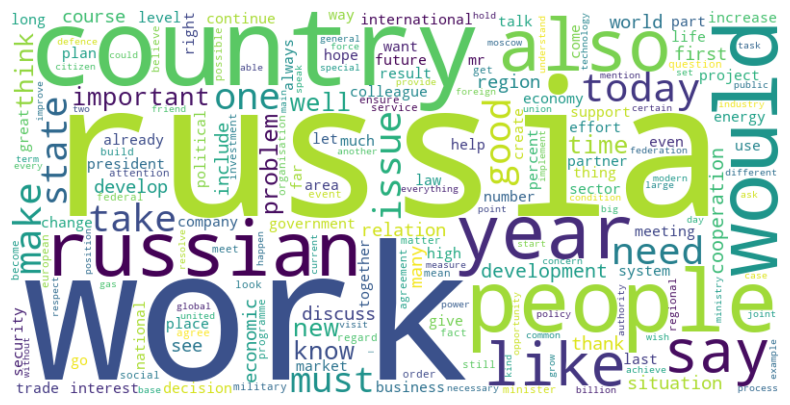

In [21]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()